In [61]:
import os, sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent))

from preprocess import VN30, preprocess_v1
from sklearn.preprocessing import StandardScaler

# Bước 1: Tiền xử lý dữ liệu

In [62]:
_ = preprocess_v1('ACB', lag=30, val=0.2, verbose=True)

=== Preprocessing ACB ===
Train shape: (970, 201), Val shape: (243, 201), Test shape: (296, 201)


# Bước 2: Huấn luyện mô hình

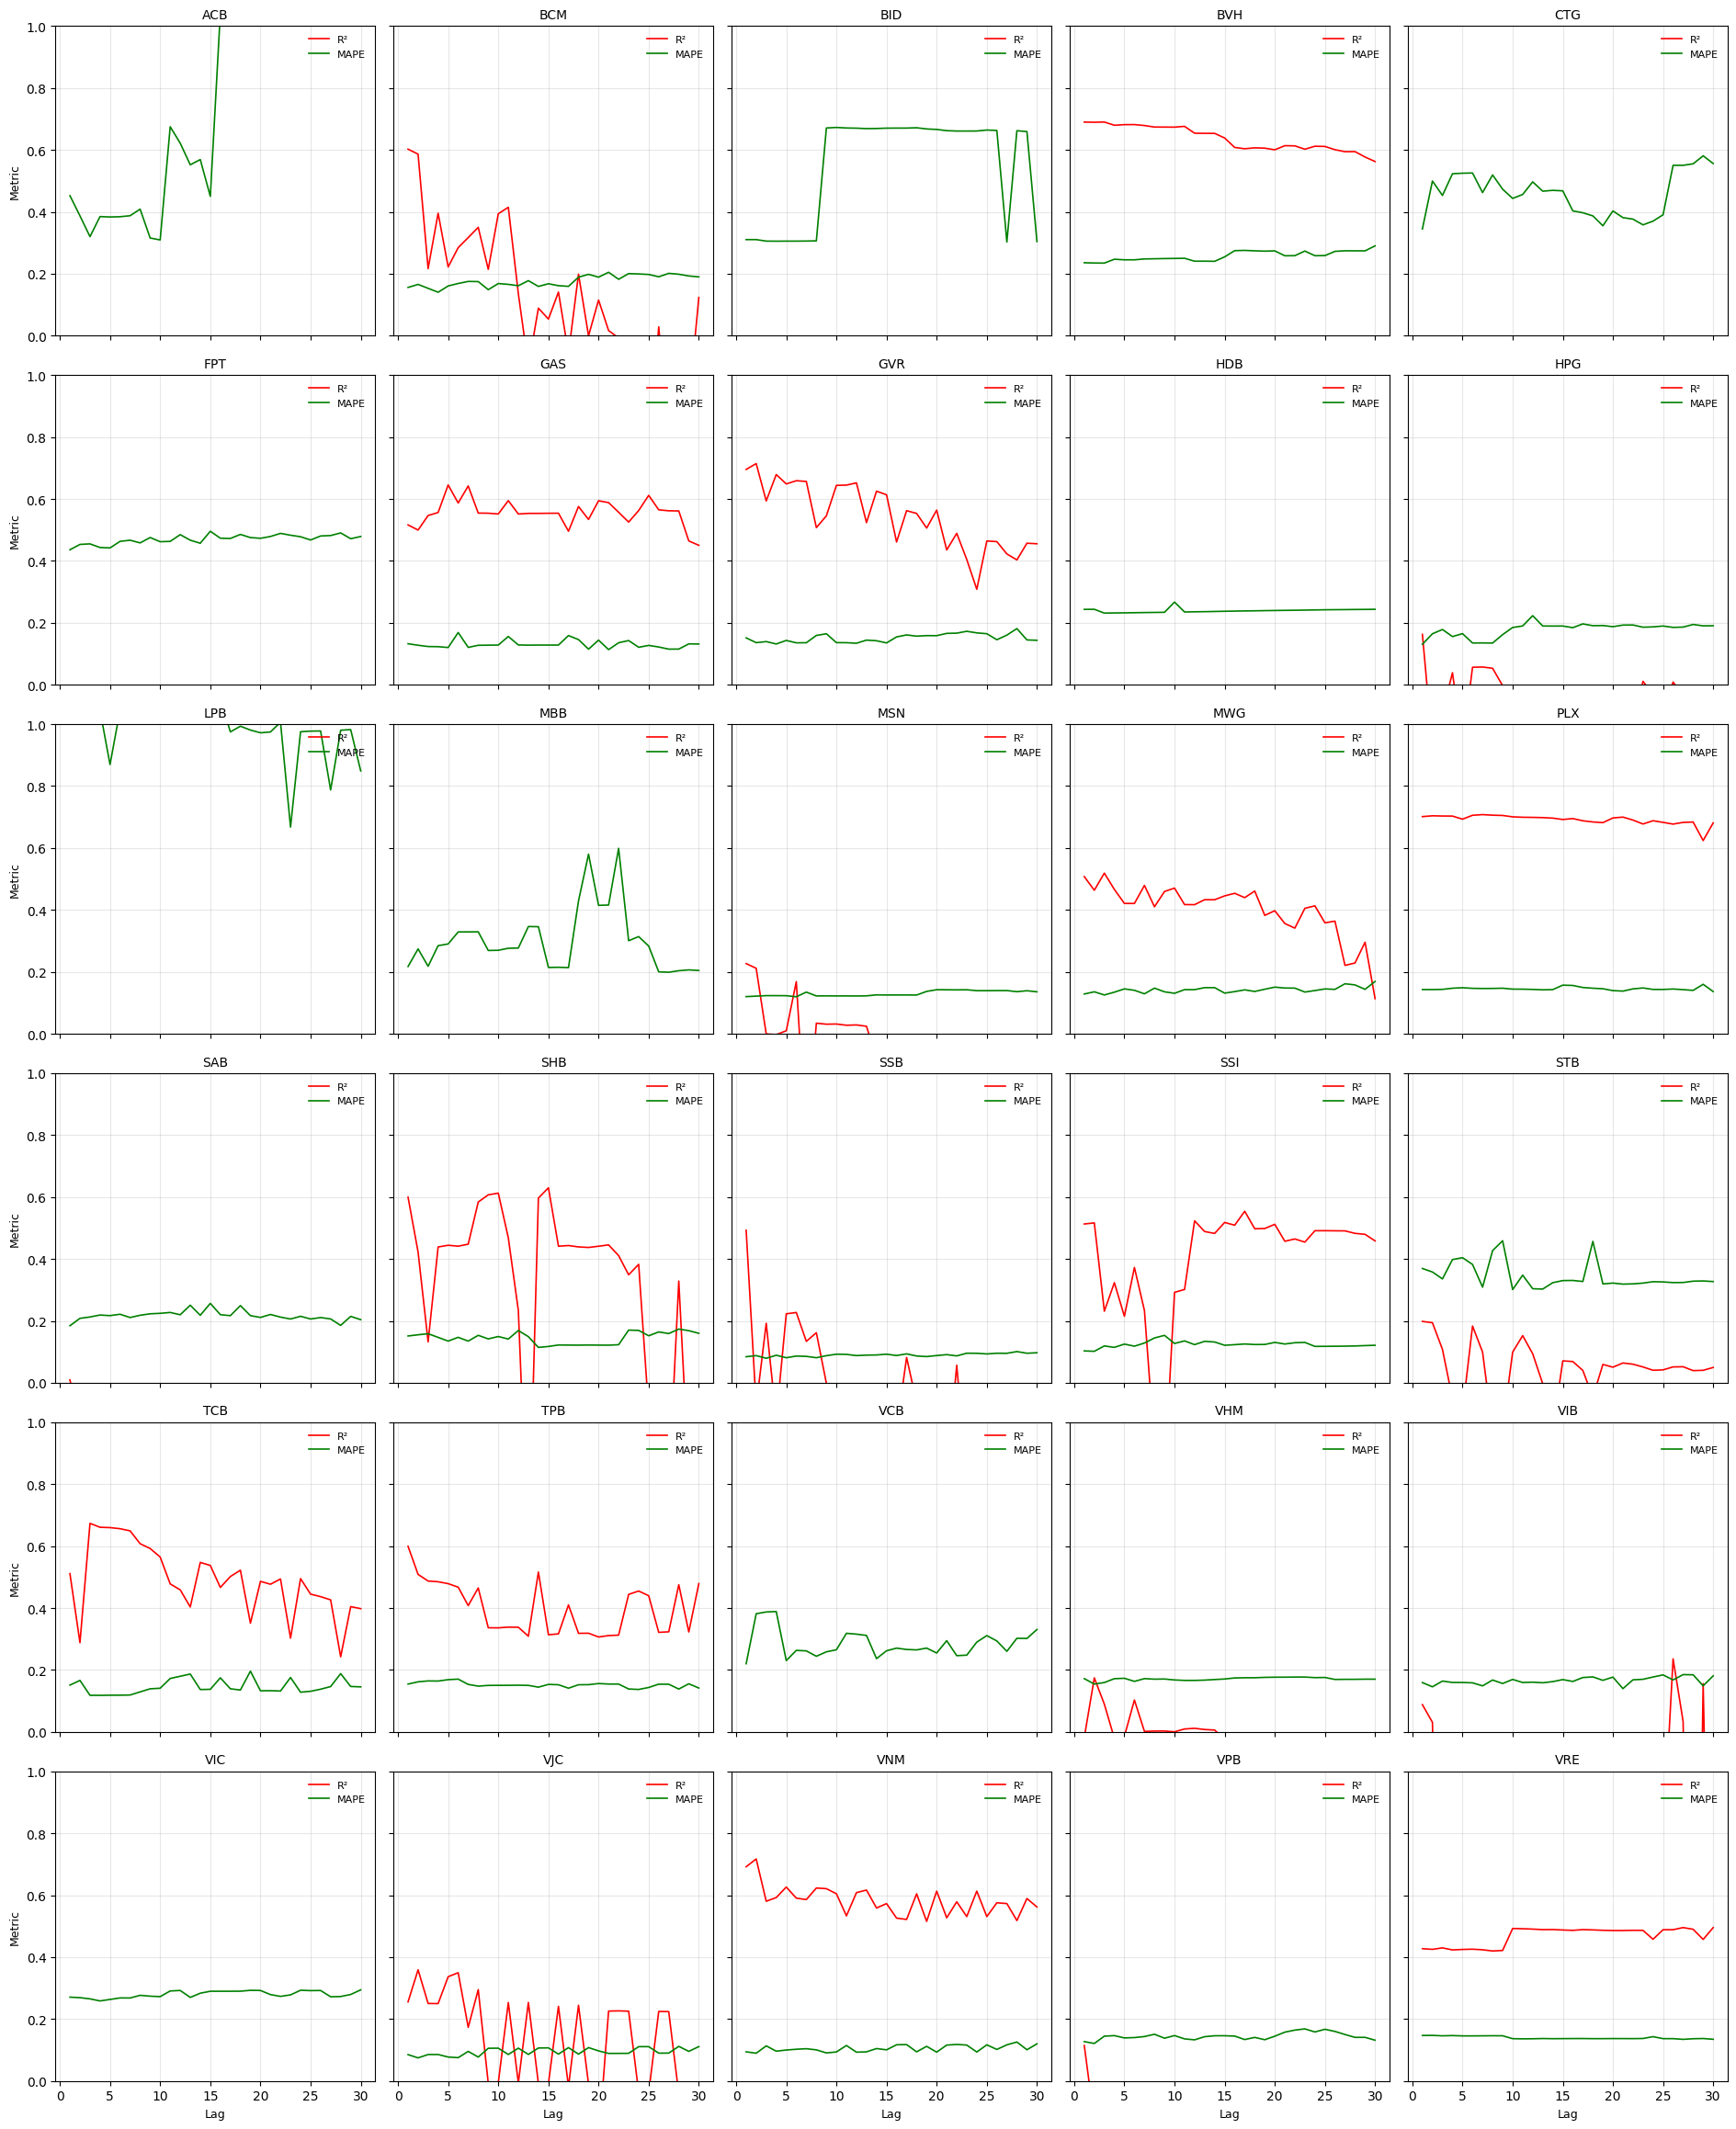

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Danh sách lag và độ sâu cây để thử
lags = list(range(1, 31))
list_depth_dt = [i * 5 for i in range(1, 7)]

fig, axes = plt.subplots(6, 5, figsize=(20, 24), sharex=True, sharey=True)

for idx, symbol in enumerate(VN30):
    r2_list = []
    mape_list = []

    # Tính R² và MAPE cho mỗi lag
    for lag in lags:
        data = preprocess_v1(
            symbol,
            lag=lag,
            val=0.2,
            calendar_feature=False,
            rolling_feature=False,
            technical_feature=False,
            nonlinear_feature=False,
            autocorr_feature=False,
            trend_feature=False,
        )
        X_train, Y_train = data["train"]
        X_val, Y_val = data["val"]
        X_test, Y_test = data["test"]
        target_scaler = data["scaler"]["target"]

        # Chọn max_depth tốt nhất trên tập validation
        best_r2 = -np.inf
        best_depth = None
        for depth in list_depth_dt:
            m = DecisionTreeRegressor(max_depth=depth, random_state=42)
            m.fit(X_train, Y_train)
            val = r2_score(Y_val, m.predict(X_val))
            if val > best_r2:
                best_r2, best_depth = val, depth

        # Huấn luyện lại và đánh giá trên test
        final = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
        final.fit(X_train, Y_train)
        pred_scaled = final.predict(X_test)

        # Unscale
        Y_pred = target_scaler.inverse_transform(pred_scaled)
        Y_true = target_scaler.inverse_transform(Y_test)

        # Tính metric
        r2_list.append(r2_score(Y_true, Y_pred))
        mape_list.append(mean_absolute_percentage_error(Y_true, Y_pred))

    # Vẽ lên subplot tương ứng
    row, col = divmod(idx, 5)
    ax = axes[row, col]

    ax.plot(lags, r2_list,
            linestyle='-', linewidth=1.2,
            color='red', label='R²')
    ax.plot(lags, mape_list,
            linestyle='-', linewidth=1.2,
            color='green', label='MAPE')

    ax.set_title(symbol, fontsize=10)
    ax.set_ylim(0, 1)

    # Chỉ đánh nhãn ở các trục ngoài cùng
    if row == 5:
        ax.set_xlabel('Lag', fontsize=9)
    if col == 0:
        ax.set_ylabel('Metric', fontsize=9)

    ax.legend(loc='upper right', fontsize=8, frameon=False)
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 0.95, 0.97])
plt.show()

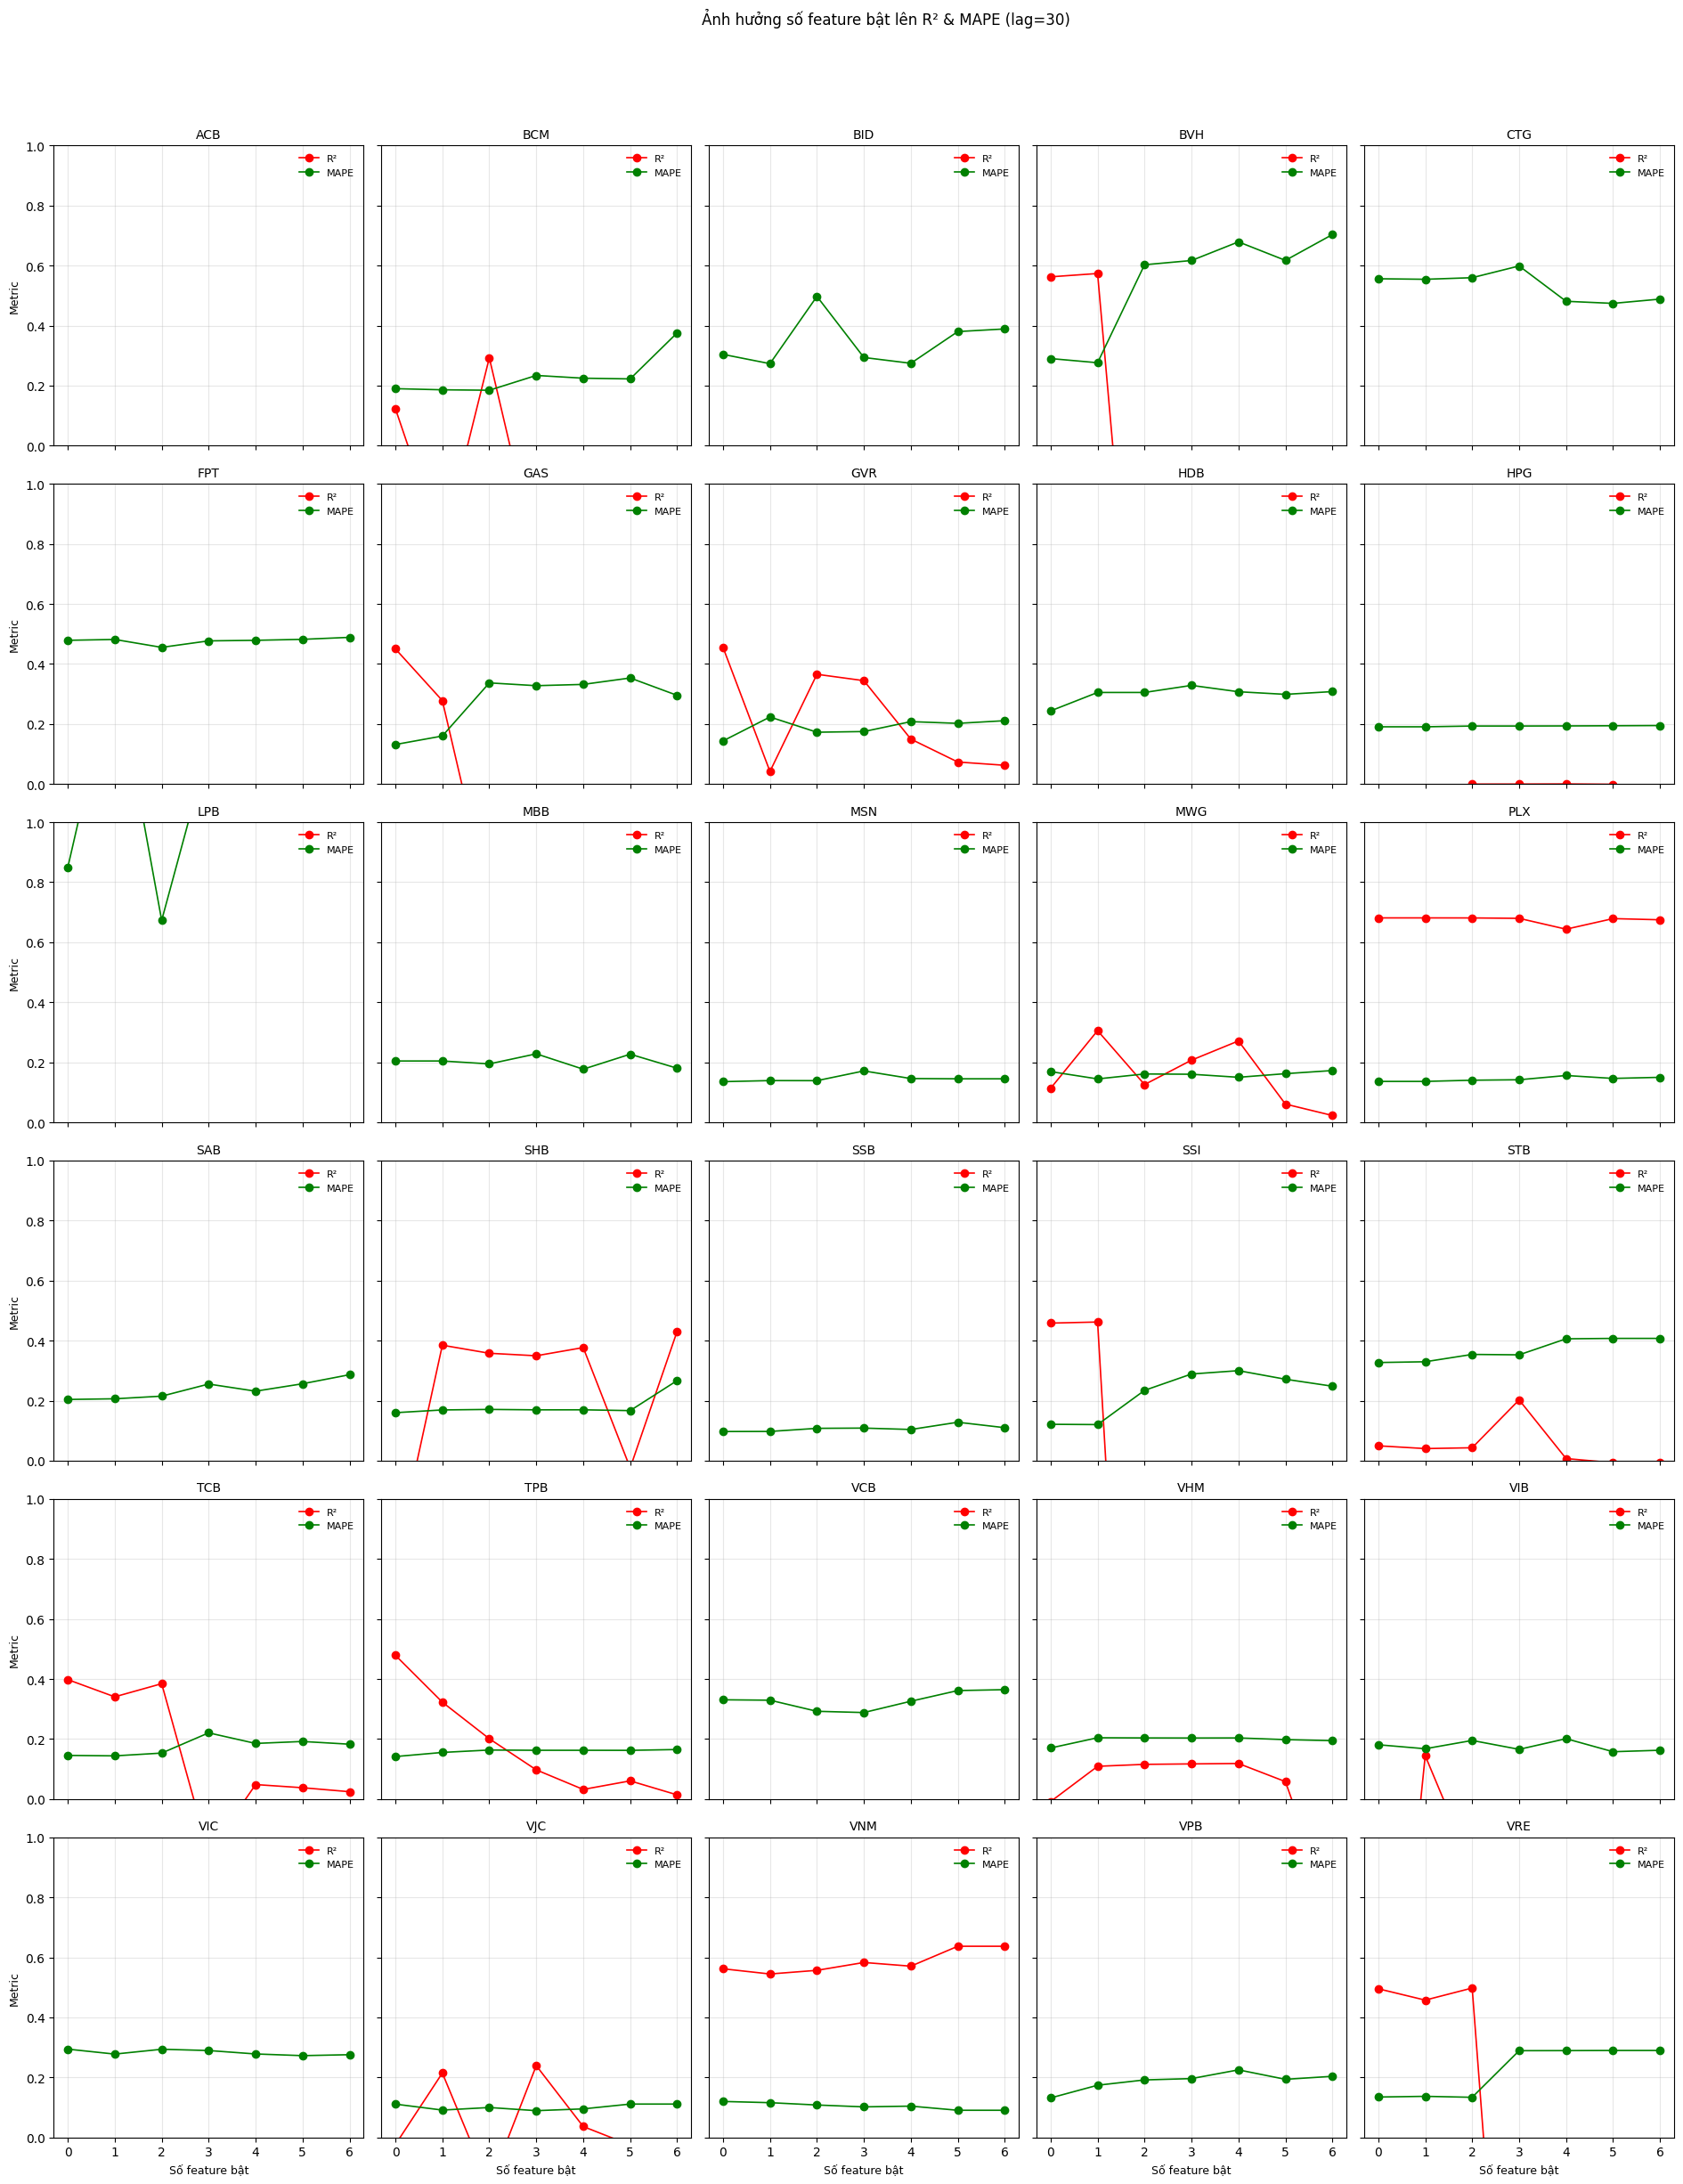

Đã lưu kết quả R² vào decision-tree.csv


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error

feature_names = [
    "calendar_feature",
    "rolling_feature",
    "technical_feature",
    "nonlinear_feature",
    "autocorr_feature",
    "trend_feature",
]

configs = [{name:(i<k) for i,name in enumerate(feature_names)} 
           for k in range(len(feature_names)+1)]

depths = [i*5 for i in range(1,7)]  

r2_matrix   = []  
mape_matrix = []

for cfg in configs:
    r2_row, mape_row = [], []
    for symbol in VN30:
        data = preprocess_v1(
            symbol,
            lag=30,
            val=0.2,
            **cfg
        )
        X_tr, Y_tr = data["train"]
        X_val, Y_val = data["val"]
        X_te, Y_te   = data["test"]
        scaler_t     = data["scaler"]["target"]

        # chọn best max_depth trên validation
        best_r2, best_d = -np.inf, None
        for d in depths:
            m = DecisionTreeRegressor(max_depth=d, random_state=42)
            m.fit(X_tr, Y_tr)
            r2_val = r2_score(Y_val, m.predict(X_val))
            if r2_val > best_r2:
                best_r2, best_d = r2_val, d

        # đánh giá trên test
        m_final = DecisionTreeRegressor(max_depth=best_d, random_state=42)
        m_final.fit(X_tr, Y_tr)
        pred_scaled = m_final.predict(X_te)
        Y_pred = scaler_t.inverse_transform(pred_scaled)
        Y_true = scaler_t.inverse_transform(Y_te)

        r2_row.append(r2_score(Y_true, Y_pred))
        mape_row.append(mean_absolute_percentage_error(Y_true, Y_pred))

    r2_matrix.append(r2_row)
    mape_matrix.append(mape_row)

n_cols = 5
n_rows = int(np.ceil(len(VN30)/n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,4*n_rows),
                         sharex=True, sharey=True)

for idx, symbol in enumerate(VN30):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows>1 else axes[col]

    x         = list(range(len(configs)))  
    r2_list   = [r2_matrix[k][idx]   for k in x]
    mape_list = [mape_matrix[k][idx] for k in x]

    ax.plot(x, r2_list,   marker='o', linestyle='-', linewidth=1.2,
            color='red',   label='R²')
    ax.plot(x, mape_list, marker='o', linestyle='-', linewidth=1.2,
            color='green', label='MAPE')

    ax.set_title(symbol, fontsize=10)
    ax.set_ylim(0,1)
    if row == n_rows-1:
        ax.set_xlabel("Số feature bật", fontsize=9)
    if col == 0:
        ax.set_ylabel("Metric", fontsize=9)
    ax.legend(loc='upper right', fontsize=8, frameon=False)
    ax.grid(alpha=0.3)

total = n_rows*n_cols
for j in range(len(VN30), total):
    r, c = divmod(j, n_cols)
    ax = axes[r, c] if n_rows>1 else axes[c]
    ax.axis('off')

plt.tight_layout(rect=[0,0,0.95,0.97])
plt.suptitle("Ảnh hưởng số feature bật lên R² & MAPE (lag=30)", y=1.02)
plt.show()

out_file = "decision-tree.csv"
with open(out_file, "w", encoding="utf-8", buffering=1) as writer:
    writer.write("sep=,\n")
    writer.write("[R-squared] Flags," + ",".join(VN30) + "\n")
    for i, row in enumerate(r2_matrix):
        vals = ",".join(f"{v:.4f}" for v in row)
        writer.write(f"{i},{vals}\n")

print(f"Đã lưu kết quả R² vào {out_file}")


# Bước 3: Đánh giá mô hình